## Data Import and Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

from datetime import datetime
import folium
import folium.plugins
from scipy import stats

The Washington DC government posts all of its public Data via the [Open Data Portal](https://opendata.dc.gov/). Parking Enforcement data is available in a variety of formats on a month by month basis. I downloaded that datasets in bulk and stitched them together into the dataset being imported below. I am hosting it for the time being on my personal dropbox. Over time, that may change.

In [3]:
data = pd.read_csv('/Users/azel/Documents/Data Sets/DC Data/Parking Enforcement/Combined /Parking Violations.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print()
print(data.info())
print()
print(data.isnull().sum())
print()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14424762 entries, 0 to 14424761
Data columns (total 19 columns):
X                        float64
Y                        float64
OBJECTID                 int64
ROWID_                   float64
DAY_OF_WEEK              object
HOLIDAY                  float64
WEEK_OF_YEAR             float64
MONTH_OF_YEAR            float64
ISSUE_TIME               float64
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
LOCATION                 object
RP_PLATE_STATE           object
BODY_STYLE               object
ADDRESS_ID               int64
STREETSEGID              float64
XCOORD                   int64
YCOORD                   int64
TICKET_ISSUE_DATE        object
dtypes: float64(8), int64(4), object(7)
memory usage: 2.0+ GB
None

X                              0
Y                              0
OBJECTID                       0
ROWID_                   2595214
DAY_OF_WEEK              4432946
HOLIDAY                  4432946
WEEK_O

,X,Y,OBJECTID,ROWID_,DAY_OF_WEEK,HOLIDAY,WEEK_OF_YEAR,MONTH_OF_YEAR,ISSUE_TIME,VIOLATION_CODE,VIOLATION_DESCRIPTION,LOCATION,RP_PLATE_STATE,BODY_STYLE,ADDRESS_ID,STREETSEGID,XCOORD,YCOORD,TICKET_ISSUE_DATE
0,-76.990883,38.901329,24651355,15241.0,THURSDAY,0.0,36.0,9.0,2109.0,P012,DISOBEYING OFFICIAL SIGN,1200 BLOCK I ST NE NORTH SIDE,NY,4D,801937,2090.0,400791,137052,2011-09-01T00:00:00.000Z
1,-77.028853,38.917009,24651356,15242.0,THURSDAY,0.0,36.0,9.0,2158.0,P039,PARK AT EXPIRED METER,1300 BLOCK U ST NW NORTH SIDE,MD,4D,809133,7819.0,397498,138793,2011-09-01T00:00:00.000Z
2,-77.013880,38.888564,24651357,15243.0,THURSDAY,0.0,36.0,9.0,927.0,P036,PARK IN OFFICIAL PARKING PERMIT ONLY SPACE,200 MARYLAND AV SW,DC,TK,801240,1186.0,398796,135635,2011-09-01T00:00:00.000Z
3,-77.054309,38.926666,24651358,15244.0,THURSDAY,0.0,36.0,9.0,107.0,P172,FAILURE TO SECURE DC TAGS,2600 BLOCK GARFIELD ST NW NORTH SID,NJ,4D,806063,5205.0,395291,139866,2011-09-01T00:00:00.000Z
4,-77.023957,38.897877,24651359,15245.0,THURSDAY,0.0,36.0,9.0,1011.0,P199,PARK IN A DESIGNATED ENTRANCE,700 9TH ST NW BLOCK EAST SIDE,DC,NaN,813593,11702.0,397922,136669,2011-09-01T00:00:00.000Z


The first step is to get rid of columns I don't need and rename the remaining columns to a format that is more comfortable to type. Next I work on filling in various NAN  values. The only Violation Description worth filling was the value associated with violation code "PO76". For reference, utlize:  
[DC Muniicipal Regulations Title 18](https://dcregs.dc.gov/Common/DCMR/ChapterList.aspx?TitleNum=18)
[DC Final Adjudication](https://dmv.dc.gov/sites/default/files/dc/sites/dmv/publication/attachments/AdjudicationDispositionRptJan2011.pdf)

Since the dataframe still contains more than 300 unique Violation Codes, the next step is to bin those in to general Violation names.

The final step is to return those Violation Descriptions to the main Dataset.

In [5]:
data = (data.drop(columns = ['OBJECTID','ROWID_','DAY_OF_WEEK','HOLIDAY','WEEK_OF_YEAR','MONTH_OF_YEAR','ISSUE_TIME',
                             'XCOORD','YCOORD','ADDRESS_ID'])
        .rename(columns = {'VIOLATION_DESCRIPTION':'Violation Description','VIOLATION_CODE': 'Violation Code',
                           'STREETSEGID': 'Block ID', 'LOCATION':'Address','RP_PLATE_STATE':'License Plate State', 
                           'BODY_STYLE':'Body Style','TICKET_ISSUE_DATE':'Ticket Issue Date', 'Y': 'Latitude',
                           'X': 'Longitude'}))

na_map = {"P076" : 'ROSA'}
mask = data['Violation Description'].isnull()
data.loc[ mask , 'Violation Description' ] = data.loc[mask, 'Violation Code'].map(na_map)

data['License Plate State'] = data['License Plate State'].fillna('NA')
data['Body Style'] = data['Body Style'].fillna('Other')


In [6]:
meter_violations = ('PARK AT EXPIRED METER','FAIL TO DISPLAY A MULTISPACE METER RECEIPT',
                    'PARK OVERTIME AT A METER','EXPIRATION TIME ON METER RECEIPT LAPSED',
                   'METER, FAIL TO DEPOSIT PAYMENT','EXPIRED HANDICAP METER',
                    'FAIL TO DISPLAY METER RECEIPT IN A LOADING ZONE','NOT PARKED IN A METER SPACE',
                    'OVERSIZED COMM VEHICLE PARKED AT A METER','IND. W/ DISABILITIES METER  NO PROOF OF PAYMENT',
                   'FAIL TO DISPLAY MULTI SPACE RECEIPT BALLPARKEVENT','ILLEGAL AT METER',
                   'FAIL TO DISPLAY MULTI SPACE RECEIPT  BALLPARKEVENT','OVERTIME AT A MULTISPACE METER IN A LOADING ZONE',
                   'FAIL TO PROPERLY DISPLAY MULTISPACE METER RECEIPT','FAIL TO DISPLAY MULTI-SPACE METER RECEIPT PROPERLY',
                   'FAIL TO DISPLAY RESIDENTIAL PARKING PERMIT','FAIL TO DEPOSIT COIN IN METER','OVERSIZED VEHICLE AT METER BALL PARK EVENT')
temp_restrictions = ('NO PARKING STREET CLEANING','NO STOPPING OR STANDING IN PM RUSH HOUR ZONE',
                    'NO STOPPING OR STANDING IN AM RUSH HOUR ZONE','EMERGENCY NO PARKING',
                    'NO PARKING SPECIFIC HOURS','RELOCATE TOW FEE','PARKING ON SNOW EMERGENCY ROUTE WHEN PROHIBITED',
                    'NO PARKING 7 AM TO 6:30 PM')
illegal_location = ('DISOBEYING OFFICIAL SIGN','NO PARKING ANYTIME','UNAUTHORIZED VEHICLE IN LOADING ZONE',
                    'NO STANDING ANYTIME','PARKED WITHIN 25 FEET OF A STOP SIGN','PARK IN A BUS ZONE',
                    'PARK WITHIN 5 FEET OF DRIVEWAY OR ALLEY','VEHICLE ON PRIVATE/PUBLIC PROPERTY WITHOUT CONSENT',
                   'PARK WITHIN 10 FEET OF A FIRE HYDRANT','NO STOPPING ANY TIME',
                   'PARK IN RESERVED SPACE FOR MOTORCYCLES ONLY','PARK ON PUBLIC SPACE','PARK WITH LEFT WHEEL TO THE CURB',
                   'PARK LESS THAN 25 FEET FROM AN INTERSECTION','PARK IN SCHOOL ZONE','PARK LESS THAN 40 FEET FROM AN INTERSECTION',
                    'PARK ON TAXICAB STAND','PARK ON SIDEWALK OR AREA RESERVED FOR PEDESTRIANS','NO STOPPING ANYTIME',
                    'NO STOPPING OR STANDING ANYTIME','GOVERNMENT VEHICLE PARKING ONLY','PARKED ON DESIGNATED VENDOR AREA',
                   'PARK IN RESERVED EMBASSY SPACE','PARK ON OR UNDER AN ELEVATED STRUCTURE','PARK IN A FIRE LANE',
                    'PARK IN MEDIAN, ISLAND, OR SAFETY ZONE','NON-TAXI ON HACK STAND','PARKED IN A RESERVED CAR SHARING SPACE',
                    'OBSTRUCTING ENTRANCE OF PKG GARAGE','ABANDON VEHICLE ON PUBLIC/PRIVATE PROPERTY VIOL 1',
                   'PARK ON PRIVATE OR PUBLIC PROPERTY','PARK WITHIN 20 FEET OF A BUS STOP OR ZONE','VALET PARKING/STAGING ZONE',
                   'FAIL TO PARK PARALLEL','VALET PARKING/STAGING ZONE','MOTOR RUNNING UNATTENDED','PARK VEHICLE IN FRONT OF A BARRICADE',
                   'COMMERCIAL MOTOR VEHICLE - NOT OUT OF SERVICE','DANGEROUS VEHICLE ON PRIV/PUBLIC PROP VIOL 1','PARK ON MEDIAN, ISLAND, OR SAFETY ZONE',
                   'OBSTRUCT AN INTERSECTION','PARK BETWEEN ISLAND OR SAFETY ZONE','PARK WITHIN TWENTY FIVE FEET FROM A YIELD SIGN')
obstruct_traffic = ('STAND OR PARK IN ALLEY','STAND OR PARK IN ALLEY','PARK IN A DESIGNATED ENTRANCE','PARK ABREAST OF ANOTHER VEHICLE',
                  'OBSTRUCTING CROSSWALK','STOPPING, STANDING OR PARKING VEHICLE IN BIKE LANE','PARKED IN DRIVEWAY OR ALLEY TO OBSTRUCT SIDEWALK',
                  'PARK MORE THAN 12 INCHES FROM CURB','OPP OR BESIDE CONTRUCTION SITE OBSTRUCTING TRAFFIC','STREETCAR-PARK',
                   'OBSTRUCTING ENTRANCE OF PKG GARAGE, DOOR OR GATE','PARK TO REDUCE ROADWAY TO LESS THAN 10 FEET')
residential_zone = ('RESIDENTIAL PERMIT PKING BEYOND LIMIT W/O PERMIT','PARK OVERTIME IN TIMED ZONE',
                    'RESIDENTIAL PMT PKG 3RD OFFENSE CALENDAR YEAR','RESIDENTIAL PMT PKG 2ND OFFENSE CALENDAR YEAR',
                   'PARK IN OFFICIAL PARKING PERMIT ONLY SPACE','INDIVID W/ DISABILITIES ONLY UNAUTH. USE RSRVD SP',
                   'RESERVED RESIDENTIAL SPACE PERSON W/ DISABILITIES','RESERVED RESIDENTIAL SPACE PERSONS W/ DISABILTIES')
admin_violation = ('FAILURE TO DISPLAY CURRENT TAGS','NO FRONT TAGS.','FAIL TO REPORT FOR INSPECTION.',
                  'FAIL TO DISPLAY CURRENT INSPECTION STICKERS','NO REAR TAGS.','EXPIRED INSPECTION REJECTION STICKER',
                  'IMPROPER DISPLAY OF TAGS','FAIL TO DISPLAY CURRENT INSPECTION STICKER','OBSTRUCTED TAGS.',
                  'FAIL TO PROPERLY AFFIX VALIDATION STICKERS','FAIL TO REMOVE EXPIRED RESIDENTIAL PARKING PERMIT')
rosa_violation = ('FAILURE TO SECURE DC TAGS','ROSA')

In [7]:
data['Violation Bins'] = (data['Violation Description']   #Replacing values to decrease entry variety
                                      .replace(meter_violations,'Meter Violation')
                                      .replace(temp_restrictions,'Temporary Parking Restriction')
                                      .replace(illegal_location,'Illegal Parking Location')
                                      .replace(residential_zone, 'Residential Zone Violation')
                                      .replace(admin_violation, 'DMV Related Violation')
                                      .replace(rosa_violation, 'ROSA Violation')
                                      .replace(obstruct_traffic, 'Obstructing Traffic'))

In [8]:
ticket_reasons = ('Meter Violation', 'Illegal Parking Location',
       'Temporary Parking Restriction', 'Residential Zone Violation',
       'DMV Related Violation', 'ROSA Violation', 'Obstructing Traffic')

data = data.loc[data['Violation Bins'].isin(ticket_reasons)]

In [9]:
#I want the top 3 states isolated and everything else summed up as 'Other'
replace_plates = data['License Plate State'].value_counts().sort_values().head(130).index
data['License Plate State'] = data['License Plate State'].replace(replace_plates,'Other')

At this point I will drop whatever remains. I have managed to keep 99.5% of the DataFrame intact while making the information easier to work with. 

In [10]:
data = data.dropna()

I have my Datetime feature engineering. This is the most computationally strenuous cell in the notebook by a wide margin. This is the cell that I would come back and fix in the future. In the meantime, it works. I go make coffee while it runs. 

In [11]:
data['Ticket Issue Date'] = pd.to_datetime(data['Ticket Issue Date'], infer_datetime_format = True).astype(str)

monthly = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).strftime('%Y-%m')
month = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month
year = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).strftime('%Y')
weekly = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").strftime('%Y-%V')

data['Month'] = data['Ticket Issue Date'].map(month)
data['M/Y'] = data['Ticket Issue Date'].map(monthly)
data['Year'] = data['Ticket Issue Date'].map(year)
data['W/Y'] = data['Ticket Issue Date'].map(weekly)

Winter = ('12', '1', '2')
Spring = ('3', '4', '5')
Summer = ('6', '7','8')
Fall = ('9', '10', '11')

data['Season'] = (data['Month'].astype(str)
                .replace(Winter, 'Winter')
                .replace (Spring, 'Spring')
                .replace (Summer, 'Summer') 
                .replace (Fall, 'Fall'))

#data['Month'] = data['Ticket Issue Date'].map(month)

#data['Day of the Week'] = data['Day of the Week'].replace({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

The data is now tidy and free of NAN values.

In [12]:
df = data

print(df.shape)
print()
print(df.info())
print()
print(df.isnull().sum())
print()
df.head()

(14354333, 15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14354333 entries, 0 to 14424761
Data columns (total 15 columns):
Longitude                float64
Latitude                 float64
Violation Code           object
Violation Description    object
Address                  object
License Plate State      object
Body Style               object
Block ID                 float64
Ticket Issue Date        object
Violation Bins           object
Month                    int64
M/Y                      object
Year                     object
W/Y                      object
Season                   object
dtypes: float64(3), int64(1), object(11)
memory usage: 1.7+ GB
None

Longitude                0
Latitude                 0
Violation Code           0
Violation Description    0
Address                  0
License Plate State      0
Body Style               0
Block ID                 0
Ticket Issue Date        0
Violation Bins           0
Month                    0
M/Y                  

,Longitude,Latitude,Violation Code,Violation Description,Address,License Plate State,Body Style,Block ID,Ticket Issue Date,Violation Bins,Month,M/Y,Year,W/Y,Season
0,-76.990883,38.901329,P012,DISOBEYING OFFICIAL SIGN,1200 BLOCK I ST NE NORTH SIDE,Other,4D,2090.0,2011-09-01 00:00:00,Illegal Parking Location,9,2011-09,2011,2011-35,Fall
1,-77.028853,38.917009,P039,PARK AT EXPIRED METER,1300 BLOCK U ST NW NORTH SIDE,MD,4D,7819.0,2011-09-01 00:00:00,Meter Violation,9,2011-09,2011,2011-35,Fall
2,-77.013880,38.888564,P036,PARK IN OFFICIAL PARKING PERMIT ONLY SPACE,200 MARYLAND AV SW,DC,TK,1186.0,2011-09-01 00:00:00,Residential Zone Violation,9,2011-09,2011,2011-35,Fall
3,-77.054309,38.926666,P172,FAILURE TO SECURE DC TAGS,2600 BLOCK GARFIELD ST NW NORTH SID,Other,4D,5205.0,2011-09-01 00:00:00,ROSA Violation,9,2011-09,2011,2011-35,Fall
4,-77.023957,38.897877,P199,PARK IN A DESIGNATED ENTRANCE,700 9TH ST NW BLOCK EAST SIDE,DC,Other,11702.0,2011-09-01 00:00:00,Obstructing Traffic,9,2011-09,2011,2011-35,Fall


## Folium Mapping by Location

This is a lot of data. The best way to get an idea for the shape of the data over time is to visualize it. I determined that the best way to do so with a dataset is to use the "heatmap with time" folium plugin. This creates a html file that is interactive while providing a generalist look at how Parking Enforcement evolves over time. 

Heatmap with Time calls for a very specific data format. 
>**data** (list of list of points of the form [lat, lng] or [lat, lng, weight])  
– The points you want to plot. The outer list corresponds to the various time steps in sequential order. (weight is in (0, 1] range and defaults to 1 if not specified for a point)
>
>**index** (Index giving the label (or timestamp) of the elements of data. Should have):   
– the same length as data, or is replaced by a simple count if not specified.

The first function finds the data I want to plot, then returns it in the two formats needed by folium. I have the list of list, followed by the index of time values. 

In [19]:
def hot_data (violation):     # Find my Data and create an index of time values. 
    v = df.loc[df['Violation Bins'] == violation]
    date_index = v['M/Y'].sort_values().unique().tolist()
    
    a = []
# List of List
    for date in date_index:
        a.append(v.loc[v['M/Y'] == date][['Latitude', 'Longitude']].values.tolist())
    
    return a , date_index

In [20]:
def timely_heat(hot_data, date_index):
    center_map = df.loc[df['Violation Description'] == 'NO PARKING STREET CLEANING']
    m = folium.Map(location=[center_map['Latitude'].mean(), # I want this centering on 
                            center_map['Longitude'].mean()], # the Residential neighborhoods
                   zoom_start = 14,                           # Where most of the cleaning occurs. 
                   tiles = ('CartoDB dark_matter'),
                   width = '75%',  # Because Folium produces monstrously large maps. 
                   height = '75%')

    folium.plugins.HeatMapWithTime(hot_data, date_index, radius = 20, 
                                   use_local_extrema = False).add_to(m)
                                    # use_local_extreme is useful to toggle for a difference
    return m                        # perspective of weight. 

In [22]:
m , n = hot_data('Temporary Parking Restriction')
timely_heat(m,n)

Folium produces some monstrously large html files. In some cases, these files are too large to render within the notebook. Provided below is that map animated at roughly 5 frames per second. I'm specifically looking at the _Temporary Parking Restriction_ category to pick up on trends. Note the differences in volume that occur at regular intervals. 



![heatmap](https://alex-witt.github.io/img/heatmap.gif)

## Comparative Analysis

In [ ]:
pd.options.display.float_format = '{:,}'.format  #This will make things easier to read

In [ ]:
#I used this to assert the average parking violations per year in the introduction. 
find_mean = pd.crosstab(df['Violation Bins'], df['Year'], margins = True).drop(columns = ('All'))
np.mean(find_mean.iloc[7].values.tolist())


I want to look at what percentage of Parking Tickets under the category _Temporary Parking Restriction_ are related to street cleaning. To do this, I need to isolate the correct category and create a crosstab focusing on individual offenses within that category. 

In [731]:
temporary = df.loc[df['Violation Bins'] == 'Temporary Parking Restriction']
totals = (pd.crosstab(temporary['Violation Description'], temporary['Month'], margins = True)
          .drop(index = ['EMERGENCY NO PARKING','NO PARKING 7 AM TO 6:30 PM','NO PARKING SPECIFIC HOURS',
                         'NO STOPPING OR STANDING IN AM RUSH HOUR ZONE', 'NO STOPPING OR STANDING IN PM RUSH HOUR ZONE',
                         'PARKING ON SNOW EMERGENCY ROUTE WHEN PROHIBITED','RELOCATE TOW FEE'], columns = ['All'])
          .T.astype(float))
       # Getting my counts of each month summed, and then summed to show the shape over the course of years. 
totals.columns = ('Street Cleaning Violation', 'Temporary Parking Restriction')
del totals.index.name #Pesky index name getting in the way. 

###### I also want to show percentages to find the max value. 
proportion = (totals['Street Cleaning Violation'] / totals['Temporary Parking Restriction'])*100
proportion = pd.DataFrame(data = proportion.values, index = proportion.index, columns = ['% of Temp Restriction'])
proportion.sort_values(by = '% of Temp Restriction', ascending = False)

,% of Temp Restriction
4,45.06076063035014
5,43.986328408872474
10,42.9522580092238
6,42.271795208593296
9,41.377243466353484
7,40.847974334856225
8,40.31647996770612
3,37.05945901873255
2,3.7132818491501545
1,3.68346832769971


In [751]:
totals

,Street Cleaning Violation,Temporary Parking Restriction
1,"5,198.0","141,117.0"
2,"4,164.0","112,138.0"
3,"72,724.0","196,236.0"
4,"122,440.0","271,722.0"
5,"93,818.0","213,289.0"
6,"115,856.0","274,074.0"
7,"97,277.0","238,144.0"
8,"99,874.0","247,725.0"
9,"84,909.0","205,207.0"
10,"80,188.0","186,691.0"


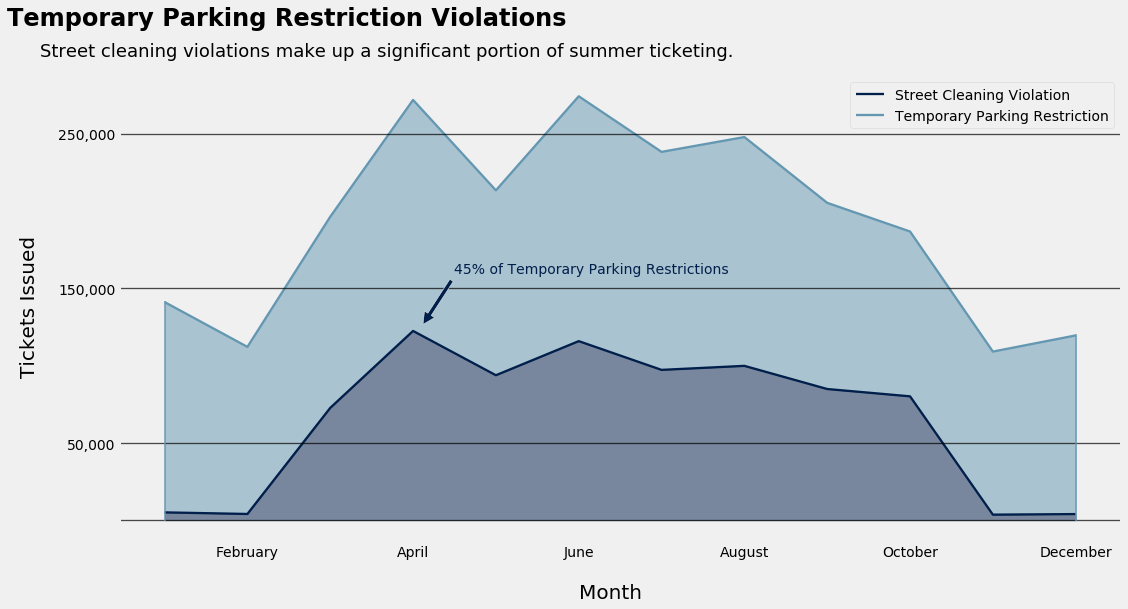

In [777]:
plt.style.use('fivethirtyeight')

ax = totals.plot.line(figsize = (16,8), linewidth = 2.3, color = ('#011f4b', '#6497b1'))

ax.set_xticklabels(['January', 'February', 'April','June','August','October','December'])
ax.set_yticks([50000, 150000, 250000])

plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)  #### Create horizontal lines to 
plt.axhline(y = 50000, color = 'black', linewidth = 1.3, alpha = .7)  # identify values without being crowded. 
plt.axhline(y = 150000, color = 'black', linewidth = 1.3, alpha = .7)  
plt.axhline(y = 250000, color = 'black', linewidth = 1.3, alpha = .7)
plt.axvline(x = 1, ymax = .515 , ymin = 0.045, color = '#6497b1', linewidth = 2, alpha = .7)
plt.axvline(x = 12, ymax = .446 , ymin = 0.045, color = '#6497b1', linewidth = 2, alpha = .7)


ax.grid(False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.fill_between(np.arange(0,12)+1, totals['Temporary Parking Restriction'],totals['Street Cleaning Violation'],color = '#6497b1', alpha = .5)
plt.fill_between(np.arange(0,12)+1, totals['Street Cleaning Violation'], [1], color = '#011f4b' , alpha = .5)

plt.text(x = 6 , y = -50000, s = 'Month',
        fontsize = 20)
plt.text(x = -.75 , y = 175000, s = 'Tickets Issued',
        fontsize = 20, rotation = 90,)
plt.text(x= -.9 , y=320000, s = "Temporary Parking Restriction Violations",
       fontsize = 24, fontweight = 'bold')
plt.text(x= -.5 , y=300000,s = "Street cleaning violations make up a significant portion of summer ticketing. ",
       fontsize = 18)
plt.annotate('45% of Temporary Parking Restrictions', xy = (4.1,125000), xytext=(4.5,160000), color = '#011f4b',
            arrowprops=dict(facecolor='#011f4b', shrink=0.05),)

plt.plot();

As expected, street cleaning tickets appear to have a direct impact on the total tickets issues in the Temporary Parking Restriction category. Next, I'll dive into revenue and how the tickets are distributed between residents and non residents of Washington DC. 

## Cleaning Revenue

Street cleaning tickets are 45 Dollars. Therefore to estimate revenue, I'll be calling up a crosstab with margins that I can then multiply by 45. That way, I have $n (tickets) * price (tickets) $. This revenue appears to sit in the range (3,7) and stays around 4 million. 

In [719]:
cleaning = df.loc[df['Violation Description'] == 'NO PARKING STREET CLEANING']
cleaning_revenue = (pd.crosstab(cleaning['Month'], 
                                cleaning['Year'], 
                                margins = True)
                    .replace(0,np.nan)
                    .interpolate()*45).astype(float).reset_index()
cleaning_revenue

Year,Month,2011,2012,2013,2014,2015,2016,2017,2018,All
0,1,"15,030.0","51,210.0","36,585.0","57,510.0","22,005.0","7,380.0","32,490.0","11,700.0","233,910.0"
1,2,"25,875.0","34,020.0","31,815.0","21,330.0","22,950.0","13,050.0","21,735.0","16,605.0","187,380.0"
2,3,"29,205.0","988,920.0","528,885.0","320,287.5","429,435.0","549,630.0","357,390.0","389,115.0","3,272,580.0"
3,4,"599,805.0","1,101,510.0","596,250.0","619,245.0","543,825.0","1,002,690.0","510,750.0","535,725.0","5,509,800.0"
4,5,"578,970.0","1,079,910.0","568,980.0","453,105.0","441,045.0","567,090.0","557,685.0","553,995.0","4,221,810.0"
5,6,"558,135.0","966,060.0","496,710.0","545,355.0","569,250.0","1,051,920.0","548,820.0","477,270.0","5,213,520.0"
6,7,"447,705.0","477,270.0","520,695.0","585,045.0","563,760.0","860,400.0","440,055.0","482,535.0","4,377,465.0"
7,8,"595,890.0","505,035.0","426,825.0","453,015.0","507,240.0","1,025,820.0","503,415.0","477,090.0","4,494,330.0"
8,9,"477,180.0","353,700.0","378,450.0","451,350.0","507,600.0","829,890.0","417,285.0","405,450.0","3,820,905.0"
9,10,"462,825.0","190,642.5","485,910.0","476,640.0","476,550.0","837,000.0","415,575.0","453,960.0","3,608,460.0"


In [720]:
yearly_revenue = cleaning_revenue.loc[cleaning_revenue['Month'] == 'All'].set_index('Month').drop(columns = 'All')

yearly_revenue

Year,2011,2012,2013,2014,2015,2016,2017,2018
Month,,,,,,,,
All,"3,264,750.0","5,616,135.0","4,118,265.0","3,699,225.0","4,115,115.0","6,827,490.0","3,832,200.0","3,819,375.0"


In [721]:
data = []
column_names = yearly_revenue.columns.values.tolist()

for column in column_names:   # I want to get rid of all those other zeros. 
    data.append(round((yearly_revenue[column] / 1000000), 2).values[:][0])
                              # Shortening the numbers will make the end result more concise
rev_shortened = pd.DataFrame(data = data).T
rev_shortened.columns = column_names

rev_shortened = rev_shortened.T.reset_index()

rev_shortened

,index,0
0,2011,3.26
1,2012,5.62
2,2013,4.12
3,2014,3.7
4,2015,4.12
5,2016,6.83
6,2017,3.83
7,2018,3.82


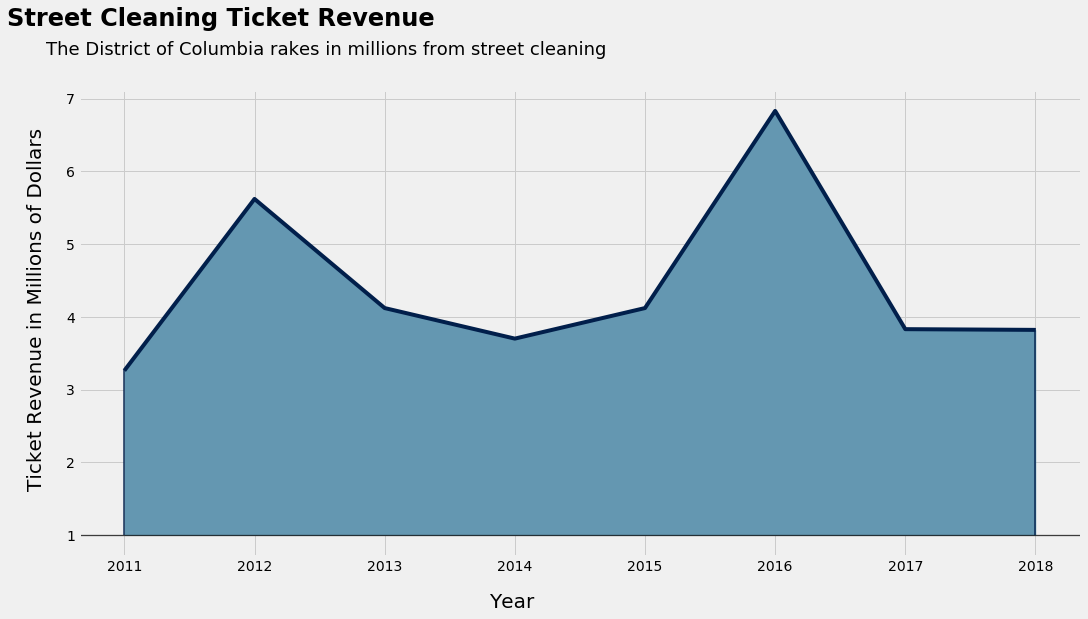

In [722]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(rev_shortened['index'], rev_shortened[0], color='#011f4b')

plt.axhline(y = 1, color = 'black', linewidth = 1.3, alpha = .7)  
plt.axvline(x = 0, ymin = .045, ymax = .4, color = '#011f4b', linewidth = 2, alpha = .7)  
plt.axvline(x = 7, ymin = 0.045, ymax = .49, color = '#011f4b', linewidth = 2, alpha = .7)  

plt.fill_between(rev_shortened['index'], rev_shortened[0],[1],color = '#6497b1', alpha = 1)

plt.text(x = 2.8 , y = 0, s = 'Year',
        fontsize = 20)
plt.text(x = -.75 , y = 6.4, s = 'Ticket Revenue in Millions of Dollars',
        fontsize = 20, rotation = 90,)
plt.text(x= -.9 , y=8, s = "Street Cleaning Ticket Revenue",
       fontsize = 24, fontweight = 'bold')
plt.text(x= -.6 , y=7.6,s = "The District of Columbia rakes in millions from street cleaning",
       fontsize = 18)

plt.plot();

## State Share

Given that street cleaning primarily occurs in residential areas, one would assume that the large majority of vehicles being ticketed would be registerd in Washington DC. However, that might not actually be the case. 

In [723]:
state_share = (pd.crosstab(cleaning['Year'],cleaning['License Plate State'], normalize = 'index')*100).reset_index() 
state_share['Non Resident'] = state_share[['MD','VA','Other']].sum(axis = 1)
state_share = state_share.drop(columns = ['MD', 'VA','Other'])
state_share.columns = ['Year','District Resident', 'Non Resident']

In [724]:
state_share

,Year,District Resident,Non Resident
0,2011,53.62508614748449,46.37491385251551
1,2012,54.31039317965113,45.68960682034887
2,2013,52.85466088267754,47.14533911732246
3,2014,50.74752144030168,49.25247855969832
4,2015,51.73379115771978,48.266208842280236
5,2016,50.583962774020904,49.416037225979096
6,2017,49.46453734147487,50.53546265852513
7,2018,48.69631811487481,51.30368188512519


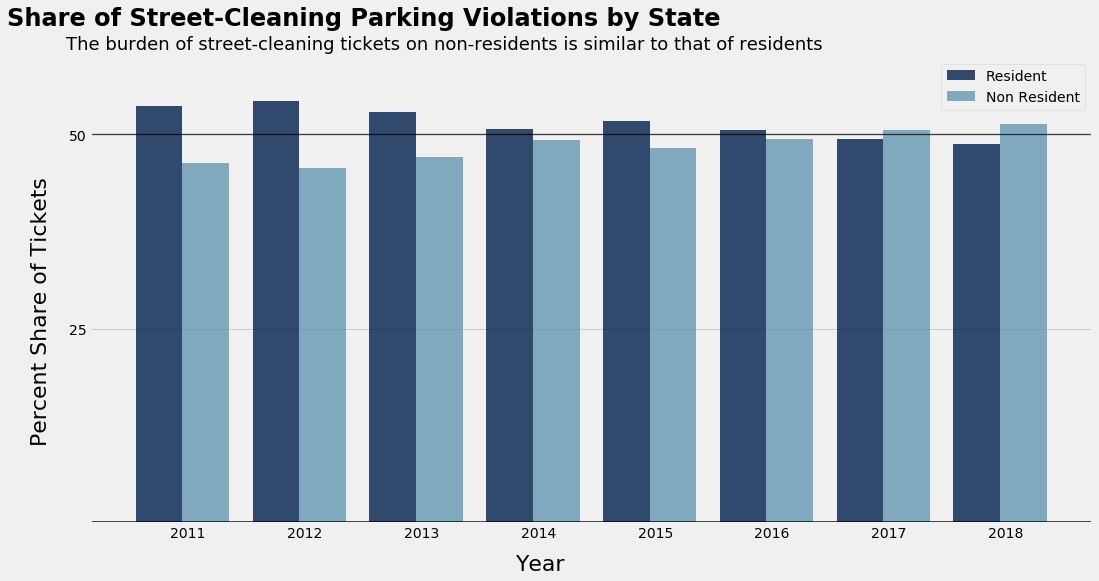

In [725]:
plt.style.use('fivethirtyeight')

n_groups = state_share['District Resident'].nunique()

fig, ax = plt.subplots(figsize=(16, 8))
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.8

residsent = plt.bar(index, state_share['District Resident'], 
              bar_width,
              alpha=opacity,
              color='#011f4b',
              label='Resident')
             

non_residet = plt.bar(index + bar_width, state_share['Non Resident'], 
              bar_width,
              alpha=opacity,
              color='#6497b1',
              label='Non Resident')

ax.set_ylim(top = 60)

plt.text(x = 3.05, y = -6, s = 'Year',
        fontsize = 22)
plt.text(x = -1.1 , y = 42.5, s = 'Percent Share of Tickets',
        fontsize = 22, rotation = 90,)
ax.text(x=-1.3,y=64, s = "Share of Street-Cleaning Parking Violations by State",
       fontsize = 24, fontweight = 'bold')
ax.text(x=-.8,y=61, s = "The burden of street-cleaning tickets on non-residents is similar to that of residents",
       fontsize = 18)

plt.axhline(y = 50, color = 'black', linewidth = 1.3, alpha = .7) 
plt.axhline(y = .2, color = 'black', linewidth = 2, alpha = .7) 
ax.set_yticks([25,50])

ax.grid(axis = 'x')

plt.xticks(index + bar_width, state_share['Year'], ha = 'right')
plt.legend()

plt.show();


Non-Resident drivers bare a higher burden than I expected. Based on this, it appears that non-residents are fined just as often of DC residents due to street cleaning parking violations. My takeaway: open sections of city blocks in Washington DC might actually might not mean that you're in luck. As always when parking in the city, double check what the sign says. 